In [ ]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm


# 你可能已經安裝的中文字體（由上到下優先）
preferred_fonts = [
    "Heiti TC",          # macOS 內建
    "PingFang TC",       # macOS 內建
    "Hiragino Sans GB",  # macOS 內建（簡中）
    "Songti SC",         # macOS 內建（簡中）
    "Arial Unicode MS",  # 跨平台
    "Noto Sans CJK TC"   # 若有裝 Google 字體
]

# 找出系統能用的字體
available = {f.name for f in fm.fontManager.ttflist}

chosen = None
for font in preferred_fonts:
    if font in available:
        chosen = font
        break

if chosen is None:
    raise Exception("⚠ 找不到可用中文字體，請安裝 Noto Sans CJK TC。")

plt.rcParams['font.family'] = chosen
plt.rcParams['axes.unicode_minus'] = False  # 確保負號正常

print(f"✅ Matplotlib 已成功使用中文字體：{chosen}")


✅ Matplotlib 已成功使用中文字體：Heiti TC


In [4]:
import pandas as pd


# =========================
# 1. 讀取資料
# =========================
cap = pd.read_csv("data_clean/generation_capacity_long.csv")
supply = pd.read_csv("data_clean/power_supply_demand_summary.csv")

cap['period'] = pd.to_datetime(cap['period'])
supply['date'] = pd.to_datetime(supply['date'])

print(cap.head())
print(supply.head())


      period raw_period   owner_group owner technology  capacity_mw
0 1982-01-01     71年01月  nation_total    全國         合計      10158.0
1 1982-01-01     71年01月  nation_total    全國       抽蓄水力          0.0
2 1982-01-01     71年01月  nation_total    全國         火力       6514.0
3 1982-01-01     71年01月  nation_total    全國         燃煤       1405.0
4 1982-01-01     71年01月  nation_total    全國         燃油       5109.0
        date  net_peak_capacity_mw  peak_load_mw  reserve_capacity_mw  \
0 2024-01-01               30758.0       25328.0               3900.0   
1 2024-01-02               32800.0       28703.0               4517.0   
2 2024-01-03               34208.0       28996.0               5601.0   
3 2024-01-04               33596.0       29337.0               5303.0   
4 2024-01-05               33930.0       28946.0               3804.0   

   reserve_margin_pct  industrial_consumption_gwh  residential_consumption_gwh  
0               15.21                     302.784                      2

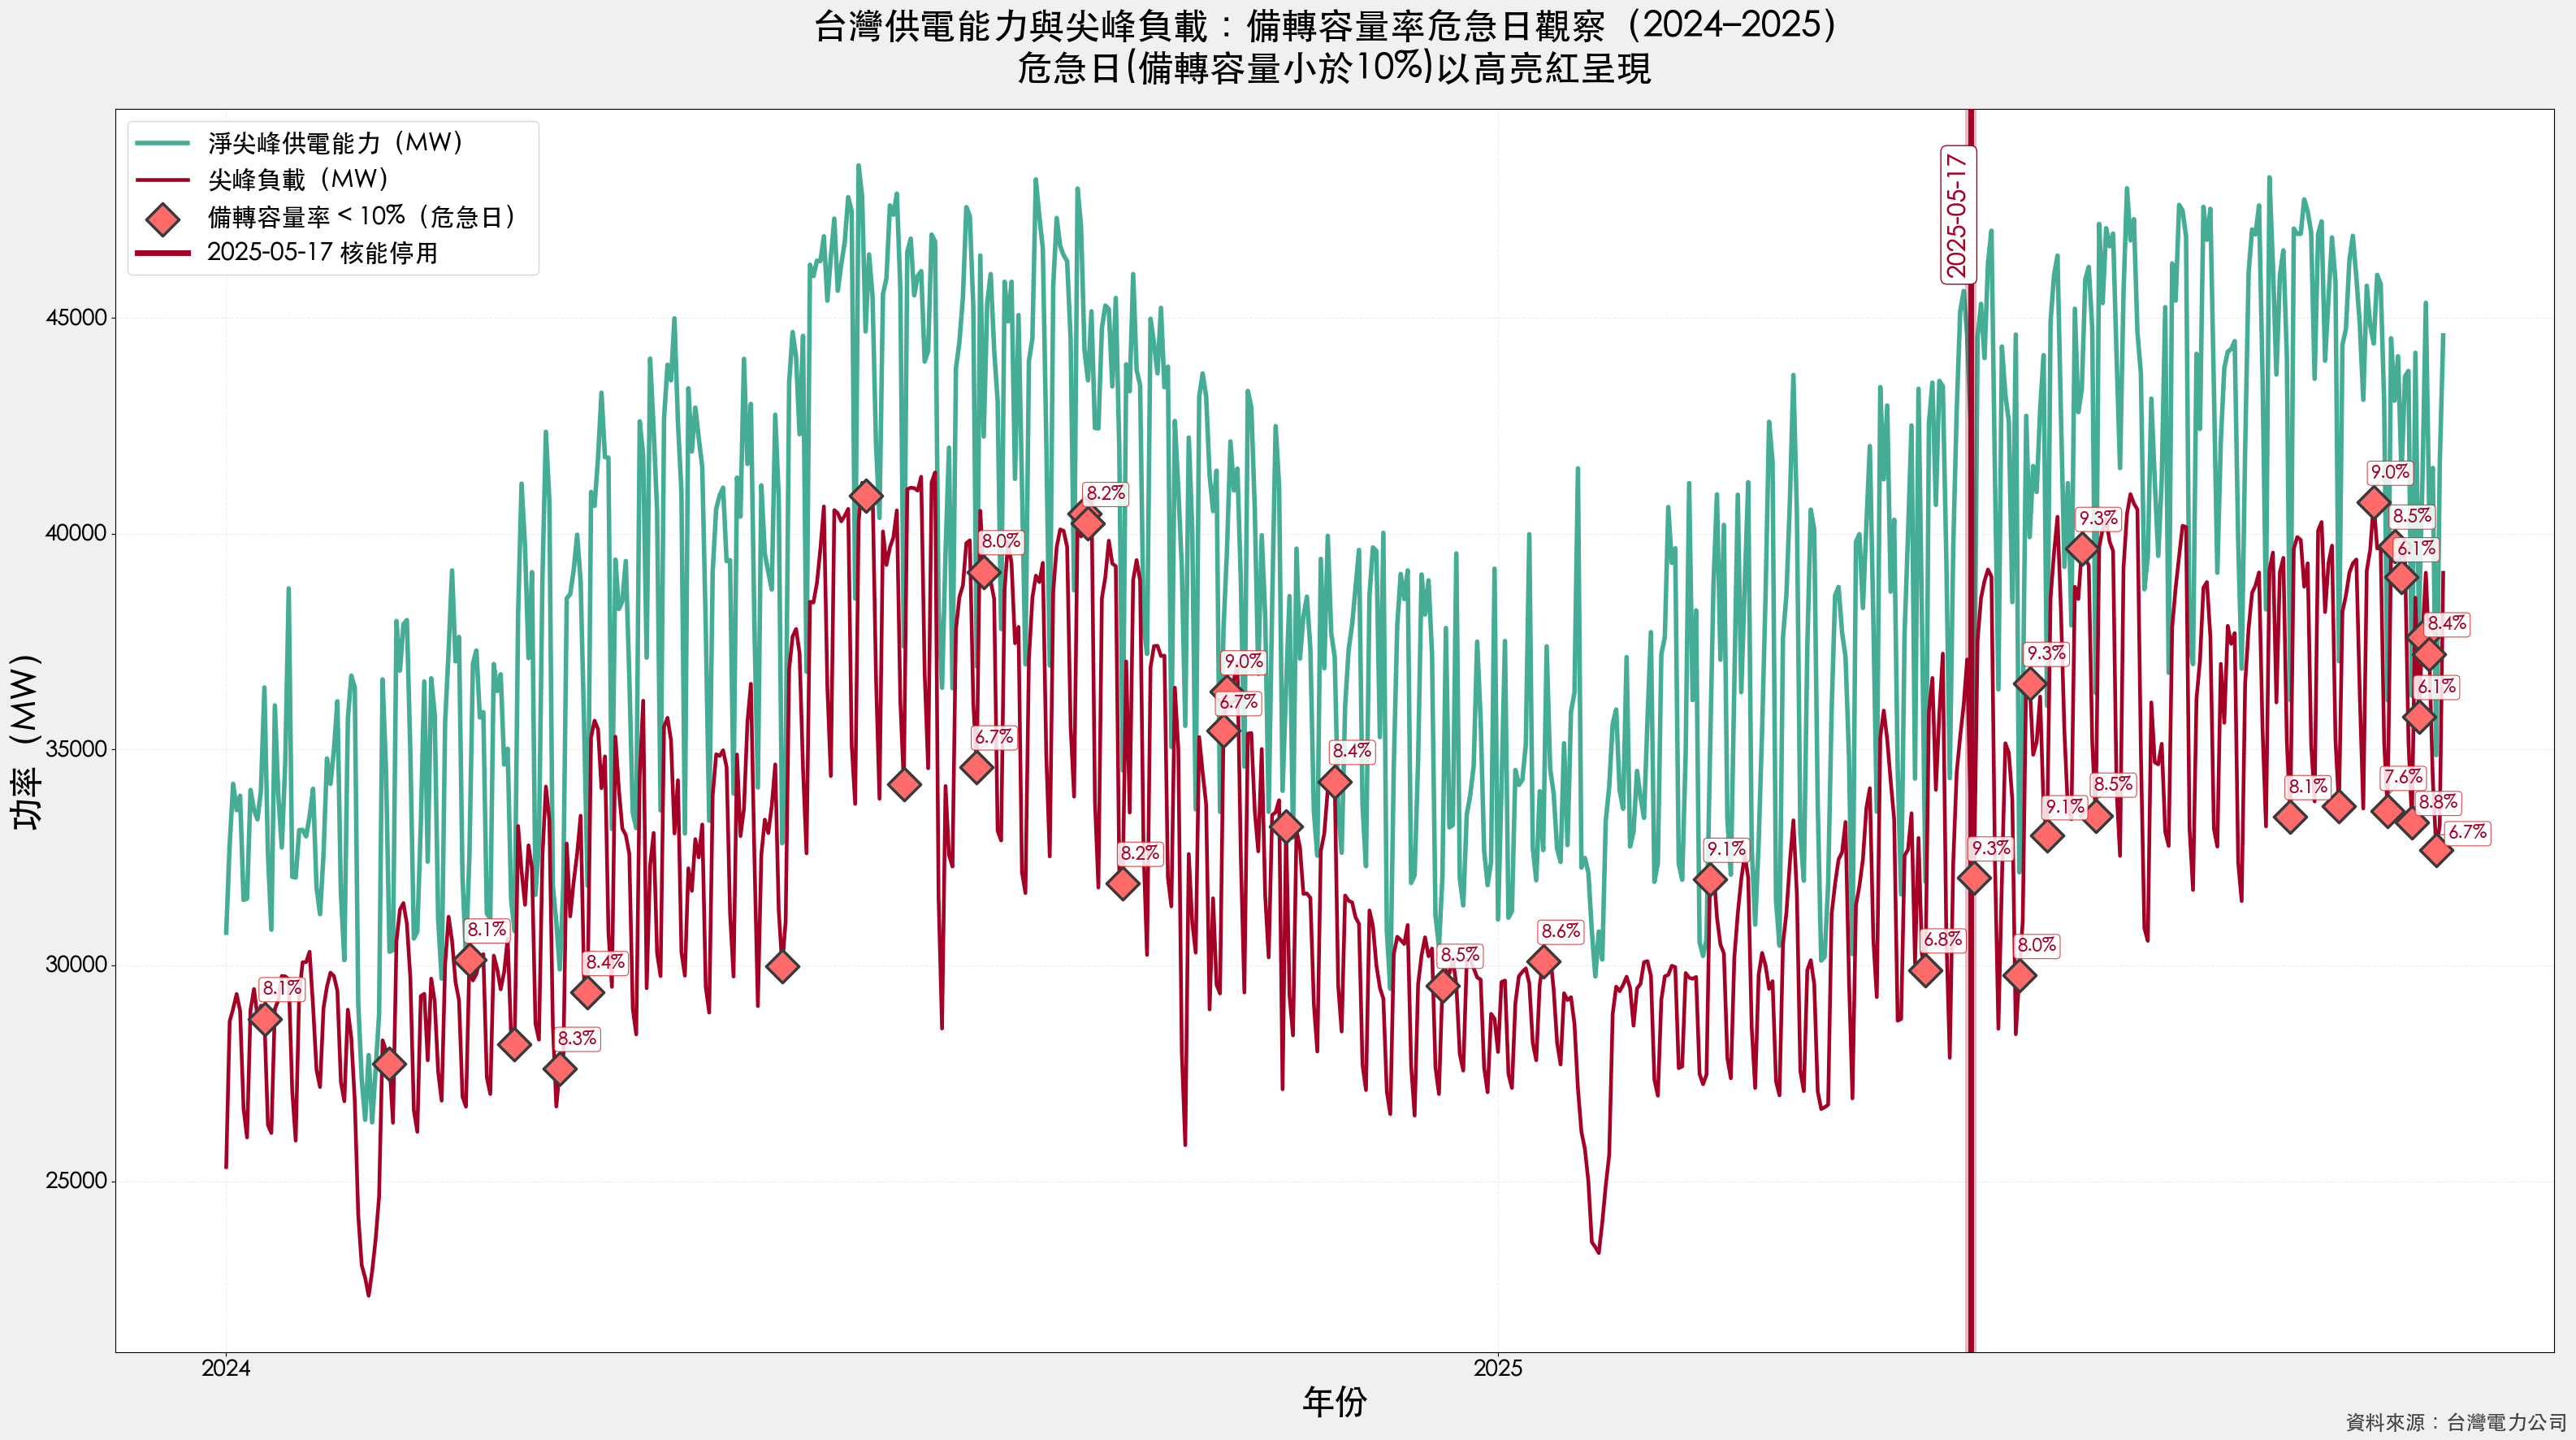

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from adjustText import adjust_text
import numpy as np
import datetime as dt

# ========== 色彩（你的主色卡 + 專業危急標示色） ==========
DEEP_CRIMSON = "#A50026"       # 主紅（事件線 / 尖峰負載）
COOL_TEAL = "#45AD96"          # 主綠（供電能力）
CRIMSON_L4 = "#D62728"         # sequential red
BG = "#F0F0F0"

# 危急點（旗艦級強調：高亮紅 + Halo 深灰邊框 + 菱形）
CRISIS_FILL = "#FF6A6A"        # 高亮紅（危急點內填色）
CRISIS_EDGE = "#3A3A3A"        # 深灰 Halo（邊框）

# ========== 字體與樣式 ==========
plt.rcParams['font.size'] = 22
plt.rcParams['axes.titlesize'] = 36
plt.rcParams['axes.labelsize'] = 30
plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 20
plt.rcParams['legend.fontsize'] = 22
plt.rcParams['figure.facecolor'] = BG
plt.rcParams['axes.facecolor'] = "white"

plt.figure(figsize=(32, 18))  

# ========== 主線：供電能力 ==========
plt.plot(
    supply['date'],
    supply['net_peak_capacity_mw'],
    color=COOL_TEAL,
    linewidth=4,
    label='淨尖峰供電能力（MW）'
)

# ========== 比較線：尖峰負載 ==========
plt.plot(
    supply['date'],
    supply['peak_load_mw'],
    color=DEEP_CRIMSON,
    linewidth=3.3,
    label='尖峰負載（MW）'
)

# ========== 危急日（備轉容量率 < 10%） → 高亮紅 + Halo + 菱形 ==========
tight = supply[supply['reserve_margin_pct'] < 10]

plt.scatter(
    tight['date'],
    tight['peak_load_mw'],
    s=420,                     
    facecolor=CRISIS_FILL,
    edgecolor=CRISIS_EDGE,
    linewidth=2.5,
    marker='D',
    zorder=9,
    label="備轉容量率 < 10%（危急日）"
)

# ========== 標記最低 30 天 ==========
lowest = tight.nsmallest(30, 'reserve_margin_pct')
texts = []

for _, row in lowest.iterrows():
    texts.append(
        plt.text(
            row['date'],
            row['peak_load_mw'] + 350,
            f"{row['reserve_margin_pct']:.1f}%",
            color=DEEP_CRIMSON,
            fontsize=16,
            ha='center',
            va='bottom',
            bbox=dict(
                boxstyle='round,pad=0.20',
                facecolor="white",
                alpha=0.85,
                edgecolor=CRIMSON_L4,
                linewidth=0.8
            ),
            zorder=10
        )
    )

# ========== 自動避開文字 ==========
adjust_text(
    texts,
    expand_text=(1.2, 1.5),
    expand_points=(1.4, 1.7),
    force_text=0.8,
    force_points=0.6,
    force_pull=0.5,
    arrowprops=dict(arrowstyle='-', color='gray', lw=1),
)

# ========== 重要事件線 ==========
event_date = dt.datetime(2025, 5, 17)

plt.axvline(event_date, color=DEEP_CRIMSON, alpha=0.28, linewidth=10, zorder=4)
plt.axvline(event_date, color=DEEP_CRIMSON, linewidth=5, zorder=8, label="2025-05-17 核能停用")

plt.text(
    event_date,
    plt.ylim()[1] * 0.98,
    "2025-05-17",
    rotation=90,
    va='top',
    ha='right',
    fontsize=22,
    color=DEEP_CRIMSON,
    bbox=dict(facecolor="white", edgecolor=DEEP_CRIMSON, boxstyle="round,pad=0.25"),
    zorder=9
)

# ========== X 軸 ==========
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

# ========== 標題 ==========
plt.title(
    "台灣供電能力與尖峰負載：備轉容量率危急日觀察（2024–2025）\n"
    "危急日(備轉容量小於10%)以高亮紅呈現",
    fontsize=32,
    pad=25
)

plt.xlabel("年份")
plt.ylabel("功率（MW）")
plt.grid(alpha=0.22, linestyle='--')

plt.figtext(0.995, 0.01, "資料來源：台灣電力公司", ha='right', fontsize=18, color="#444")

plt.legend(loc="upper left")
plt.tight_layout()
plt.show()
